# Leukemia Semantic Segmentation by U-Net 
This noteboook referred to the following notebook.<br/>
https://www.kaggle.com/code/dikshabhati2002/image-segmentation-u-net

### About U-Net
from https://arxiv.org/abs/1505.04597<br/>
The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. We show that such a network can be trained end-to-end from very few images and outperforms the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. 

# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Dataset Preparation

In [2]:
files=[]
paths = []
for dirname, _, filenames in os.walk('../input/leukemia/Original/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        files.append(filename)

In [3]:
mpaths = []
for dirname, _, filenames in os.walk('../input/leukemia/Segmented/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        mpaths.append(path)

In [4]:
df0=pd.DataFrame(columns=['file','path','mpath'])
df0['file']=sorted(files)
df0['path']=sorted(paths)
df0['mpath']=sorted(mpaths)
display(df0)
df=df0.iloc[0:len(df0)//2]
test_df=df0.iloc[len(df0)//2:]

file  \
0    WBC-Malignant-Pro-001.jpg   
1    WBC-Malignant-Pro-002.jpg   
2    WBC-Malignant-Pro-003.jpg   
3    WBC-Malignant-Pro-004.jpg   
4    WBC-Malignant-Pro-005.jpg   
..                         ...   
799  WBC-Malignant-Pro-800.jpg   
800  WBC-Malignant-Pro-801.jpg   
801  WBC-Malignant-Pro-802.jpg   
802  WBC-Malignant-Pro-803.jpg   
803  WBC-Malignant-Pro-804.jpg   

                                                  path  \
0    ../input/leukemia/Original/Pro/WBC-Malignant-P...   
1    ../input/leukemia/Original/Pro/WBC-Malignant-P...   
2    ../input/leukemia/Original/Pro/WBC-Malignant-P...   
3    ../input/leukemia/Original/Pro/WBC-Malignant-P...   
4    ../input/leukemia/Original/Pro/WBC-Malignant-P...   
..                                                 ...   
799  ../input/leukemia/Original/Pro/WBC-Malignant-P...   
800  ../input/leukemia/Original/Pro/WBC-Malignant-P...   
801  ../input/leukemia/Original/Pro/WBC-Malignant-P...   
802  ../input/leukemia/Original/Pro/WBC-Malignant-P...   
803  ../input/leukemia/Original/Pro/WBC-Malignant-P...   

                                                 mpath  
0    ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
1    ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
2    ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
3    ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
4    ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
..                                                 ...  
799  ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
800  ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
801  ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
802  ../input/leukemia/Segmented/Pro/WBC-Malignant-...  
803  ../input/leukemia/Segmented/Pro/WBC-Malignant-...  

[804 rows x 3 columns]

In [5]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [6]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

2022-10-11 10:58:00.300879: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def display(display_list):
    plt.figure(figsize=(12,12))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2022-10-11 10:58:00.759494: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


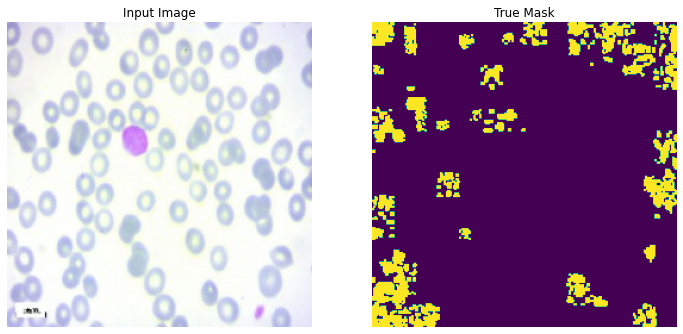

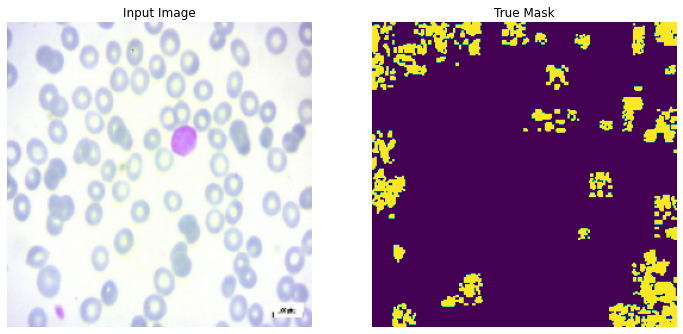

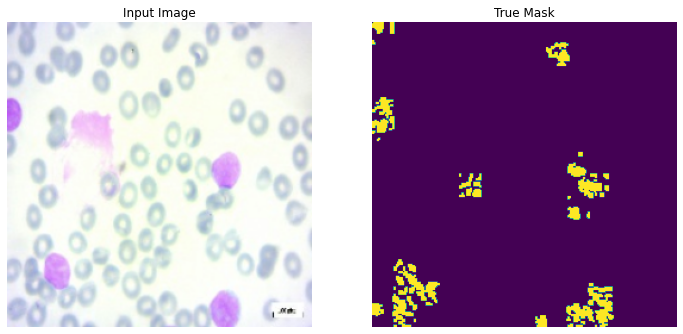

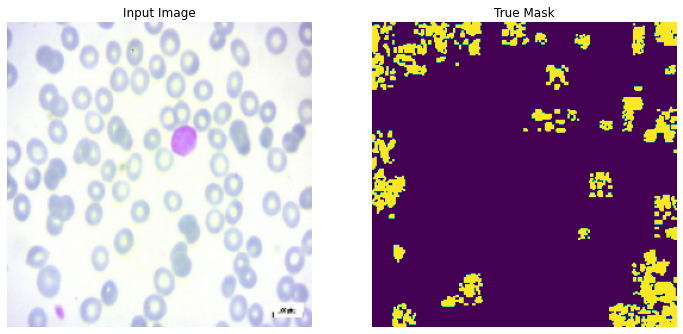

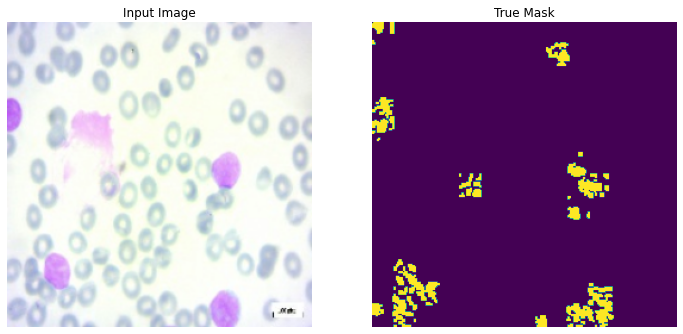

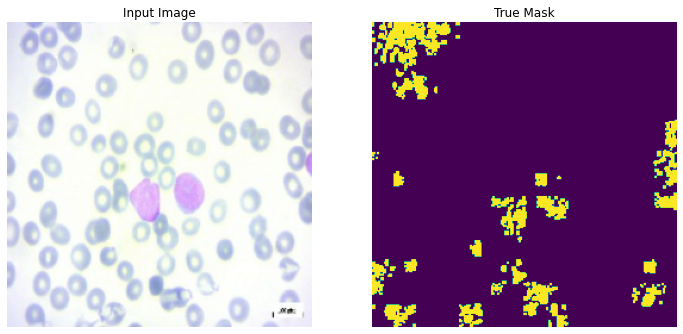

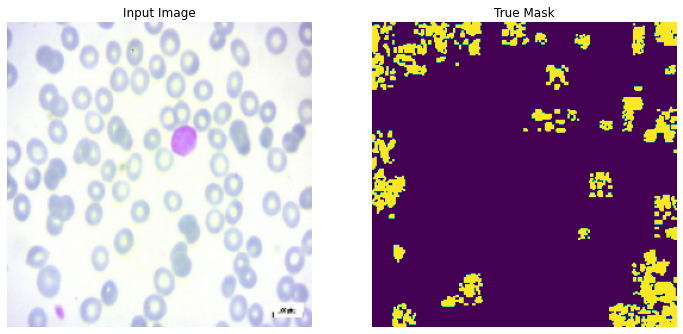

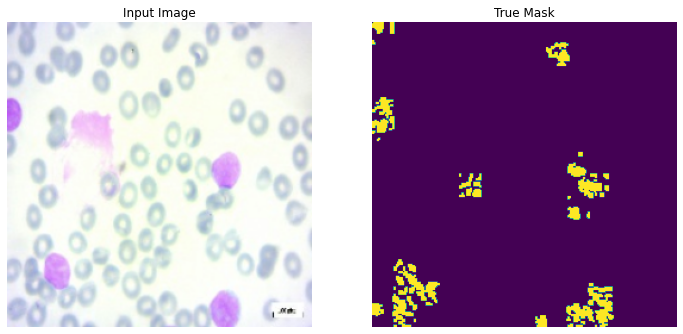

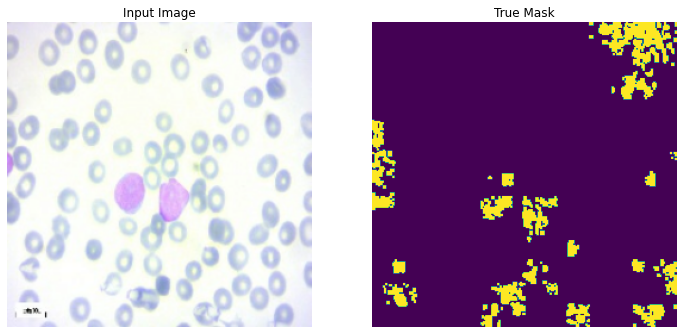

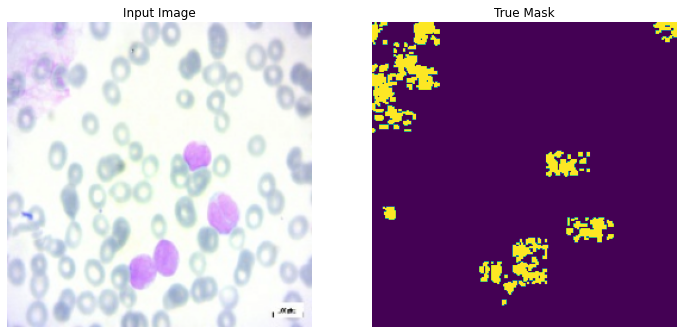

In [10]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

# MobileNetV2 Model

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Train the Model

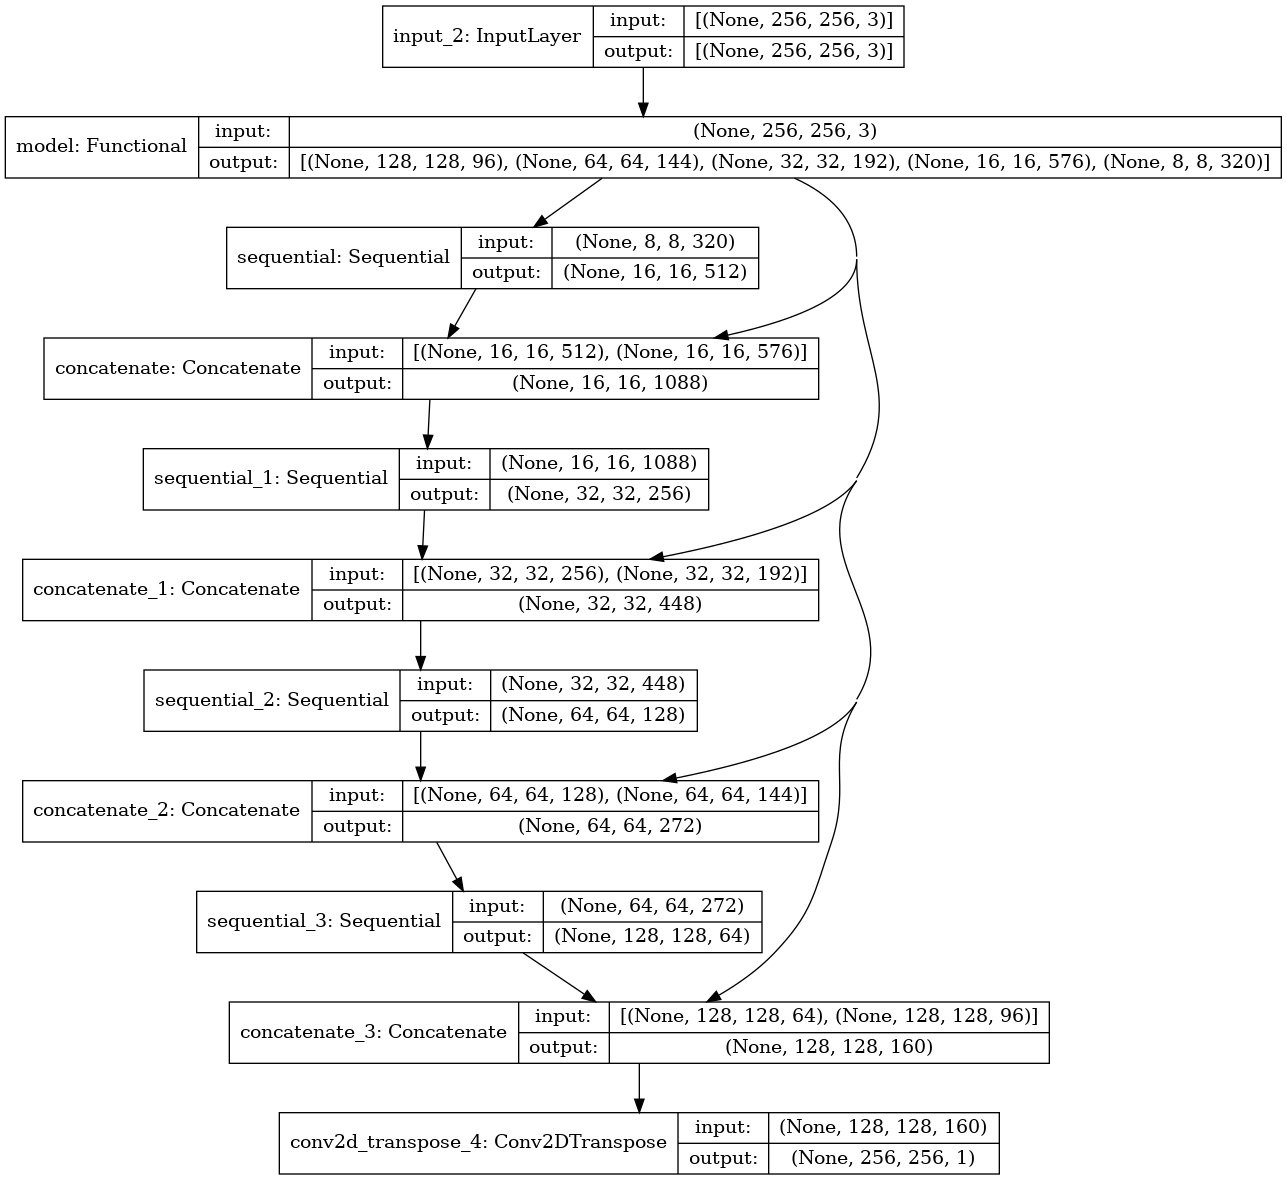

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

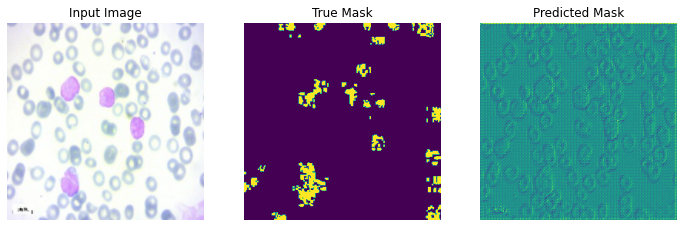

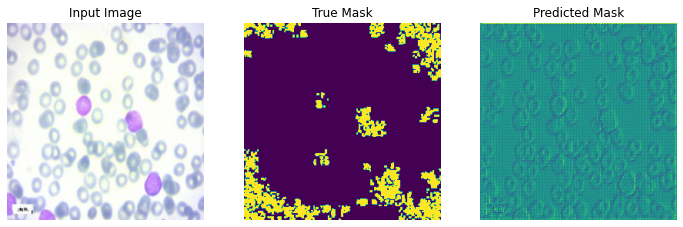

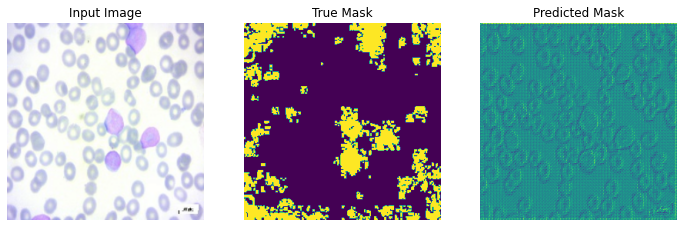

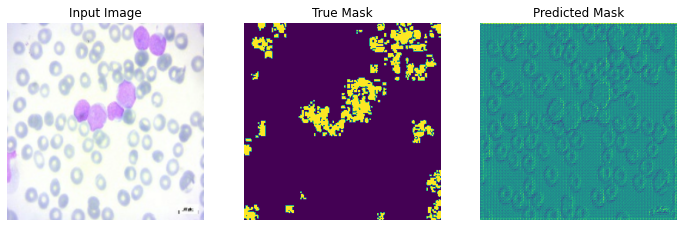

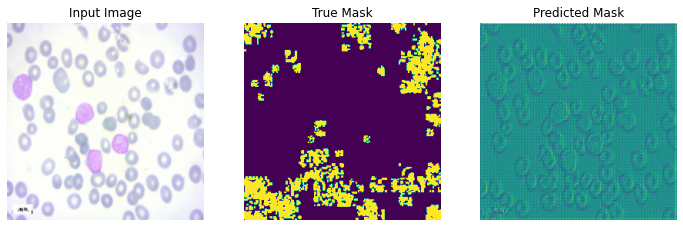

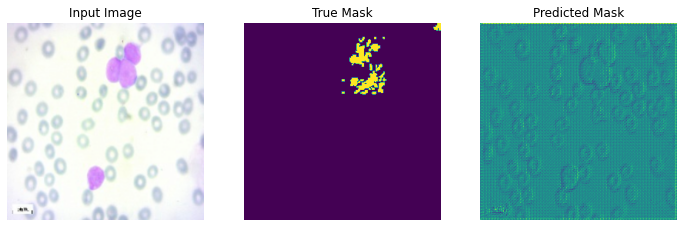

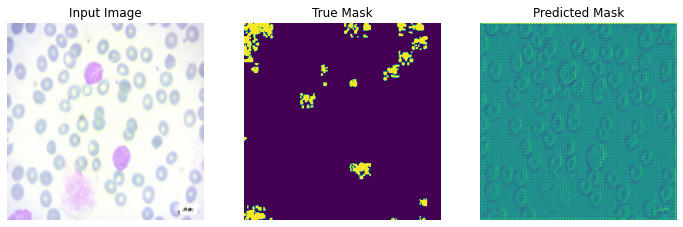

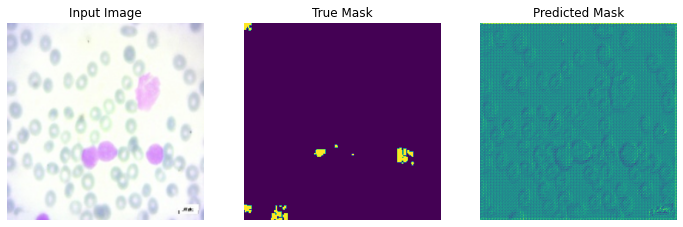

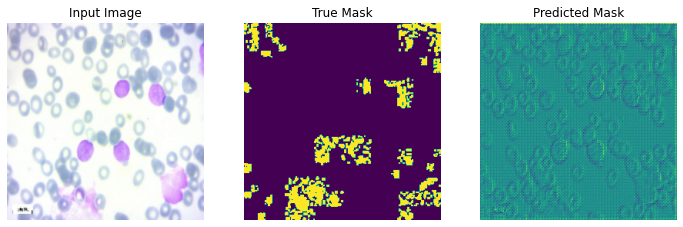

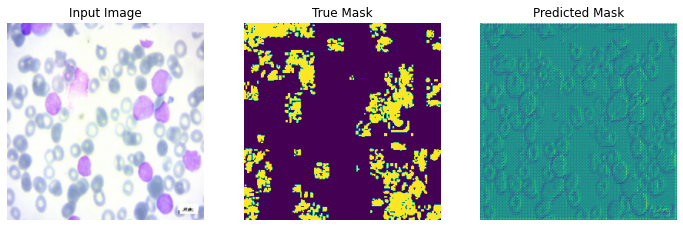

In [16]:
for i in range(5):
    for images, masks in train_dataset.take(i):
        for img, mask in zip(images, masks):
            sample_image = img
            sample_mask = mask
            show_predictions(sample_image, sample_mask)
            break

In [17]:
#model.summary()

Epoch 1/30
18/18 [==============================] - 64s 3s/step - loss: 0.6980 - dice_coef: 0.3020 - binary_accuracy: 0.5993 - val_loss: 0.6624 - val_dice_coef: 0.3423 - val_binary_accuracy: 0.6207
Epoch 2/30
18/18 [==============================] - 57s 3s/step - loss: 0.5703 - dice_coef: 0.4292 - binary_accuracy: 0.8490 - val_loss: 0.5853 - val_dice_coef: 0.4205 - val_binary_accuracy: 0.7603
Epoch 3/30


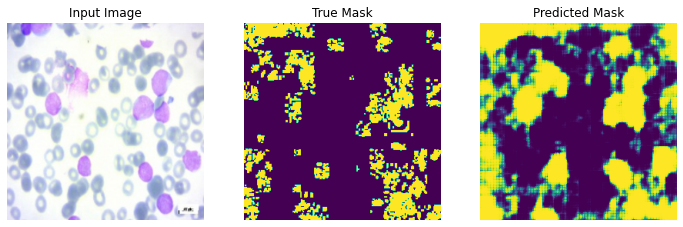

18/18 [==============================] - 57s 3s/step - loss: 0.5290 - dice_coef: 0.4711 - binary_accuracy: 0.8645 - val_loss: 0.5628 - val_dice_coef: 0.4424 - val_binary_accuracy: 0.7947
Epoch 4/30
18/18 [==============================] - 56s 3s/step - loss: 0.5098 - dice_coef: 0.4904 - binary_accuracy: 0.8704 - val_loss: 0.5153 - val_dice_coef: 0.4910 - val_binary_accuracy: 0.8546
Epoch 5/30
18/18 [==============================] - 57s 3s/step - loss: 0.4968 - dice_coef: 0.5034 - binary_accuracy: 0.8680 - val_loss: 0.5089 - val_dice_coef: 0.4972 - val_binary_accuracy: 0.8656
Epoch 6/30


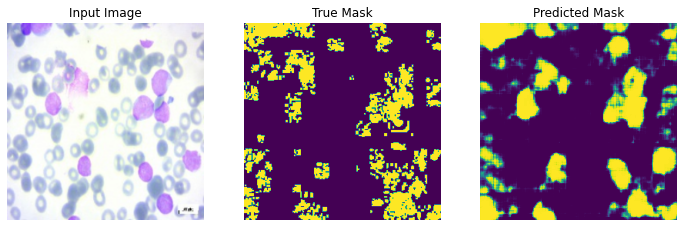

18/18 [==============================] - 58s 3s/step - loss: 0.4946 - dice_coef: 0.5054 - binary_accuracy: 0.8714 - val_loss: 0.5133 - val_dice_coef: 0.4925 - val_binary_accuracy: 0.8831
Epoch 7/30
18/18 [==============================] - 57s 3s/step - loss: 0.4884 - dice_coef: 0.5118 - binary_accuracy: 0.8744 - val_loss: 0.5086 - val_dice_coef: 0.4973 - val_binary_accuracy: 0.8732
Epoch 8/30
18/18 [==============================] - 57s 3s/step - loss: 0.4828 - dice_coef: 0.5175 - binary_accuracy: 0.8769 - val_loss: 0.5265 - val_dice_coef: 0.4783 - val_binary_accuracy: 0.8837
Epoch 9/30


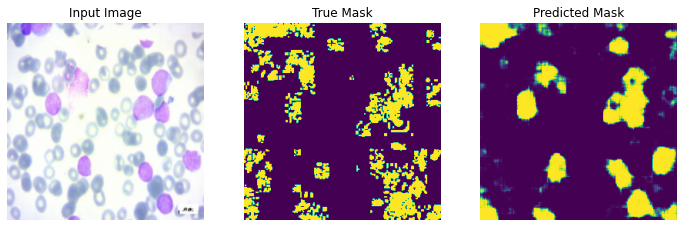

18/18 [==============================] - 57s 3s/step - loss: 0.4767 - dice_coef: 0.5230 - binary_accuracy: 0.8757 - val_loss: 0.5821 - val_dice_coef: 0.4222 - val_binary_accuracy: 0.8891
Epoch 10/30
18/18 [==============================] - 58s 3s/step - loss: 0.4790 - dice_coef: 0.5209 - binary_accuracy: 0.8778 - val_loss: 0.5884 - val_dice_coef: 0.4157 - val_binary_accuracy: 0.8883
Epoch 11/30
18/18 [==============================] - 57s 3s/step - loss: 0.4721 - dice_coef: 0.5278 - binary_accuracy: 0.8798 - val_loss: 0.5795 - val_dice_coef: 0.4247 - val_binary_accuracy: 0.8884


In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

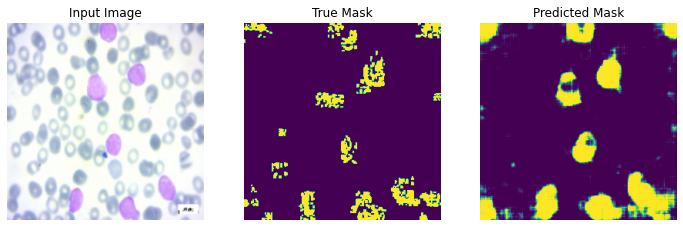

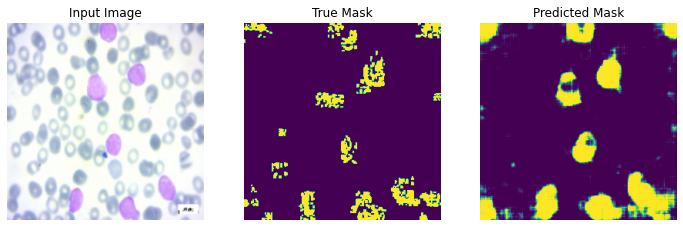

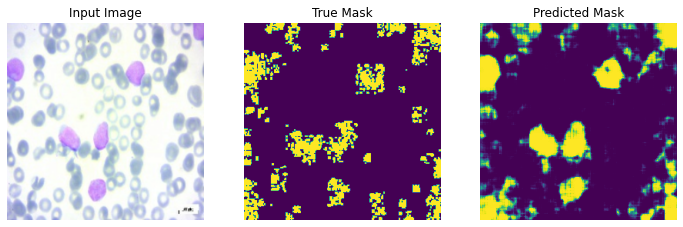

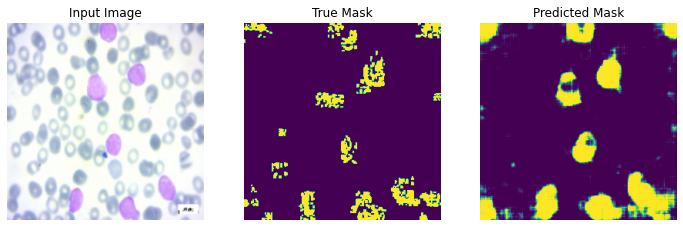

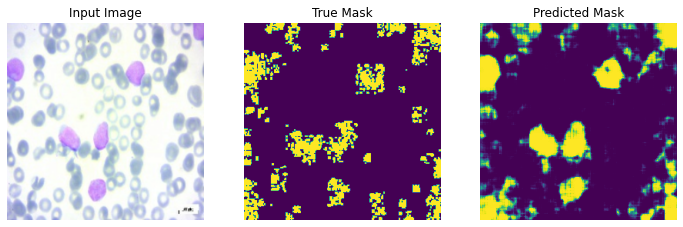

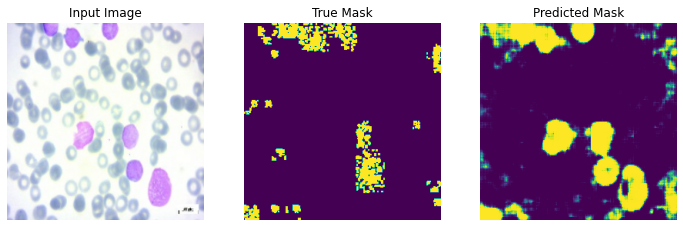

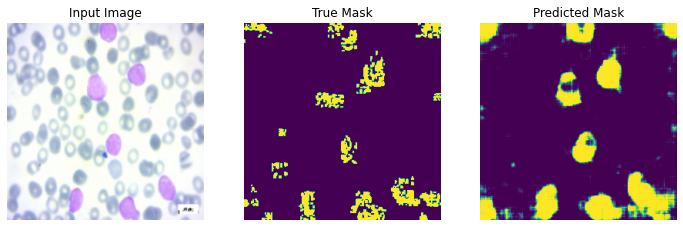

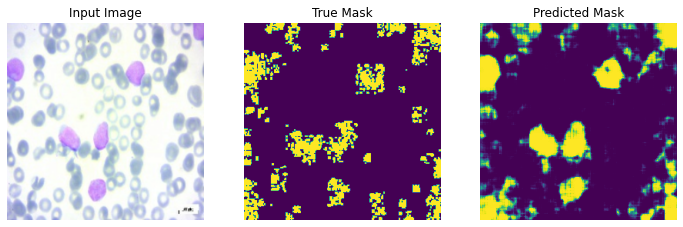

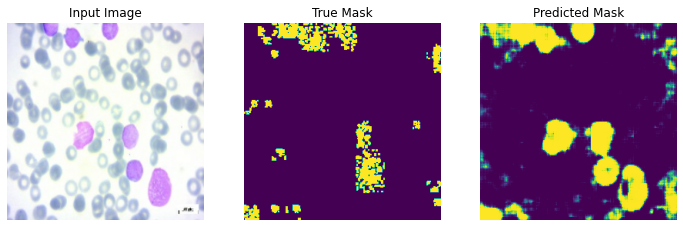

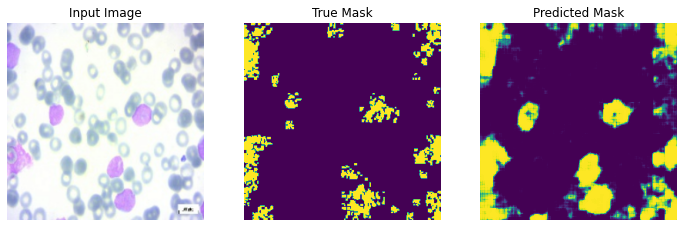

In [19]:
for i in range(5):
    for images, masks in test_dataset.take(i):
        for img, mask in zip(images, masks):
            tsample_image = img
            tsample_mask = mask
            show_predictions(tsample_image, tsample_mask)
            break